# Sentiment Analysis
Here we are preprocessing date from the CSV files, then using HuggingFace transformers and the Distilbert model to perform sentiment analysis on those reviews. Those sentiments and sentiment scores are then appended to the CSV files as DATA/oppenheimer_reviews_sentiment.csv and DATA/barbie_reviews_sentiment.csv.

In [ ]:
!pip install transformers
!pip install tensorflow

In [3]:
# Import necessary libraries
import pandas as pd
from sklearn.cluster import KMeans
from transformers import pipeline, AutoTokenizer, TFAutoModelForSequenceClassification
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

#load data from csv
barbie_df = pd.read_csv('../DATA/barbie_reviews.csv')
oppenheimer_df = pd.read_csv('../DATA/oppenheimer_reviews.csv')

#drop all reviews which don't have any words or more than 300 words (model's word limit is ~333)
barbie_df = barbie_df[barbie_df['text'].str.split(',').apply(len) >= 3]
barbie_df = barbie_df[barbie_df['text'].str.split().apply(len) <= 300]
barbie_df.reset_index(drop=True, inplace=True)
oppenheimer_df = oppenheimer_df[oppenheimer_df['text'].str.split(',').apply(len) >= 3]
oppenheimer_df = oppenheimer_df[oppenheimer_df['text'].str.split().apply(len) <= 300]
oppenheimer_df.reset_index(drop=True, inplace=True)

#create the pipeline
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = TFAutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")
sentiment_pipeline = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

#run sentiment analysis, add new feature to the dataframe with sentiment score.
#if model is not confident, label as neutral
sentiment_results = barbie_df['text'].apply(lambda x: sentiment_pipeline(x)[0])
barbie_df['sentiment'] = sentiment_results.apply(lambda x: 'neutral' if x['score'] < 0.7 else x['label'])

sentiment_results = oppenheimer_df['text'].apply(lambda x: sentiment_pipeline(x)[0])
oppenheimer_df['sentiment'] = sentiment_results.apply(lambda x: 'neutral' if x['score'] < 0.7 else x['label'])

#assign -1, 0, 1 to negative, neutral, and positive sentiments for clustering
barbie_df['sentiment_score'] = barbie_df['sentiment'].apply(lambda x: 1 if x == 'POSITIVE' else (0 if x == 'NEUTRAL' else -1))
oppenheimer_df['sentiment_score'] = oppenheimer_df['sentiment'].apply(lambda x: 1 if x == 'POSITIVE' else (0 if x == 'NEUTRAL' else -1))

#build kmeans model, add new feature to dfs with cluster numbers
num_clusters = 3

barbie_kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(barbie_df[['sentiment_score']])
barbie_df['cluster'] = barbie_df.labels_

oppenheimer_kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(oppenheimer_df[['sentiment_score']])
oppenheimer_df['cluster'] = oppenheimer_kmeans.labels_

#data vis on barbie
plt.figure(figsize=(8, 6))
barbie_df['sentiment'].value_counts().plot(kind='bar')
plt.title('Barbie Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(barbie_df.index, np.random.rand(len(barbie_df)), c=barbie_df['cluster'])
plt.title('Clustering of Barbie Sentiments')
plt.xlabel('Review Index')
plt.ylabel('Random Noise')
plt.show()

#data vis on oppenheimer
plt.figure(figsize=(8, 6))
oppenheimer_df['sentiment'].value_counts().plot(kind='bar')
plt.title('Oppenheimer Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(oppenheimer_df.index, np.random.rand(len(oppenheimer_df)), c=oppenheimer_df['cluster'])
plt.title('Clustering of Oppenheimer Sentiments')
plt.xlabel('Review Index')
plt.ylabel('Random Noise')
plt.show()

/usr/local/lib/python3.10/site-packages/huggingface_hub/utils/_runtime.py:184: UserWarning: Pydantic is installed but cannot be imported. Please check your installation. `huggingface_hub` will default to not using Pydantic. Error message: '{e}'
  warnings.warn(
2024-02-12 16:02:29.502349: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-12 16:03:02.923148: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
All PyTorch model weights were used when initializing 

AttributeError: 'DataFrame' object has no attribute 'labels_'

In [5]:
oppenheimer_df.to_csv('../DATA/oppenheimer_reviews_sentiment.csv', index=False)
barbie_df.to_csv('../DATA/barbie_reviews_sentiment.csv', index=False)


In [18]:
oppenheimer_df = pd.read_csv('../DATA/oppenheimer_reviews_sentiment.csv')
barbie_df = pd.read_csv('../DATA/barbie_reviews_sentiment.csv')

In [19]:
oppenheimer_df.head()

,score,title,date,text,sentiment,sentiment_score
0,9/10,Murphy is exceptional,07 2023,You'll have to have your wits about you and yo...,POSITIVE,1
1,10/10,A brilliantly layered examination of a man thr...,07 2023,"""Oppenheimer"" is a biographical thriller film ...",POSITIVE,1
2,8/10,Is it just me ?,07 2023,Is it just me or did anyone else find this mov...,POSITIVE,1
3,4/10,Disappointing,07 2023,It saddens me that so many people are mistakin...,NEGATIVE,-1
4,9/10,Exceptional storytelling and Genius Cinametogr...,07 2023,Just came out of the theater and watching Oppe...,POSITIVE,1


/var/folders/gy/sq_b71qx3931n7lpgb669l0w0000gq/T/ipykernel_16768/2011200807.py:9: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(df['text'].apply(len), df['sentiment_score'],  cmap='viridis')


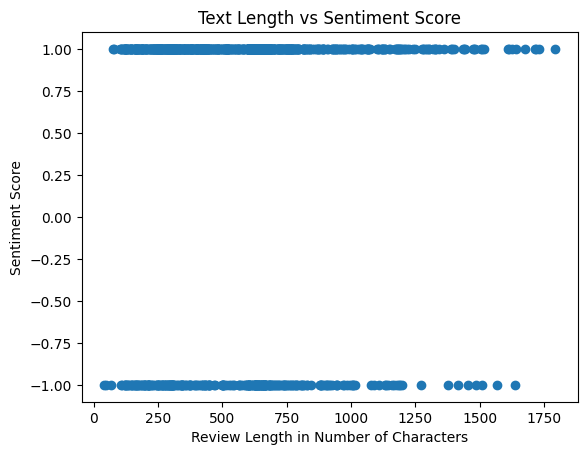

In [24]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def grid_plot(df1, df2):
    # concat both dataframes 
    df = pd.concat([df1, df2])
    # plot the legnth of the text to the sentiment_score 
    plt.scatter(df['text'].apply(len), df['sentiment_score'],  cmap='viridis')
    plt.xlabel('Review Length in Number of Characters')
    plt.ylabel('Sentiment Score')
    plt.title('Text Length vs Sentiment Score')
    plt.show()
    


# Call the function with the fixed DataFrame
grid_plot(oppenheimer_df, barbie_df)
